In [1]:
import numpy as np
import pandas as pd
import _pickle as cPickle

In [13]:
import os
from tqdm import tqdm

In [38]:
def load(path):
    with open(path, 'rb') as f:
        return cPickle.load(f)

In [49]:
cubics = [load(f'cubic_res/{path}') for path in os.listdir('cubic_res')]
dates = [c.date for c in cubics]
df_c = pd.DataFrame({'date': dates, 'obj': cubics})

In [46]:
polys = [load(f'poly_res/{path}') for path in os.listdir('poly_res')]
dates = [c.date for c in polys]
df_p = pd.DataFrame({'date': dates, 'obj': polys})
df_p.set_index('date', inplace=True)

In [45]:
svis = [load(f'svi_res/{path}') for path in os.listdir('svi_res')]
dates = [c.date for c in svis]
df_s = pd.DataFrame({'date': dates, 'obj': svis})

# Surface poly

In [294]:
poly_params = df_p['obj'].apply(lambda x: x.params)

In [339]:
kf = KalmanFilter(n_dim_state=3, n_dim_obs=5, em_vars='all')
kf = kf.em(poly_params)
mean, cov = kf.filter(poly_params)
temp = mean @ kf.observation_matrices.T + kf.observation_offsets
pred = pd.DataFrame(index=poly_params.index, data=temp, columns=poly_params.columns)

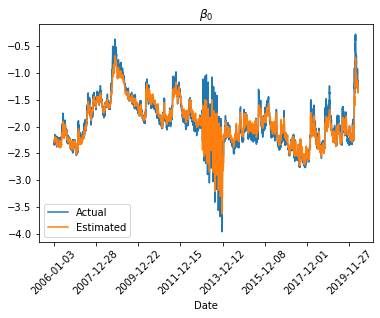

In [309]:
poly_params['const'].plot(label='Actual')
pred['const'].plot(label='Estimated')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.title(r'$\beta_0$')
plt.legend()
plt.savefig('plots/poly_beta_0.png')

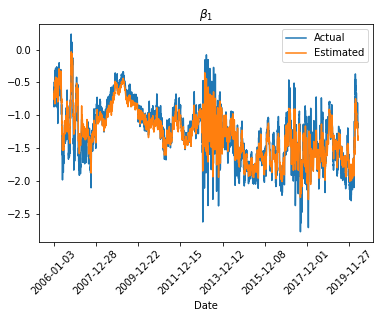

In [310]:
poly_params['x1'].plot(label='Actual')
pred['x1'].plot(label='Estimated')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.title(r'$\beta_1$')
plt.legend()
plt.savefig('plots/poly_beta_1.png')

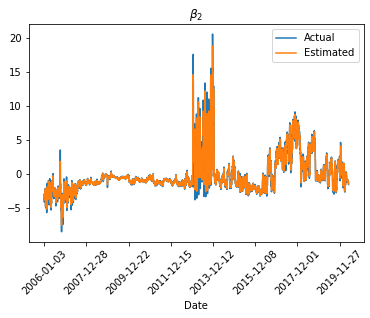

In [311]:
poly_params['x2'].plot(label='Actual')
pred['x2'].plot(label='Estimated')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.title(r'$\beta_2$')
plt.legend()
plt.savefig('plots/poly_beta_2.png')

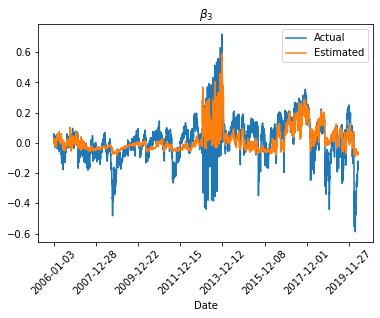

In [312]:
poly_params['x3'].plot(label='Actual')
pred['x3'].plot(label='Estimated')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.title(r'$\beta_3$')
plt.legend()
plt.savefig('plots/poly_beta_3.png')

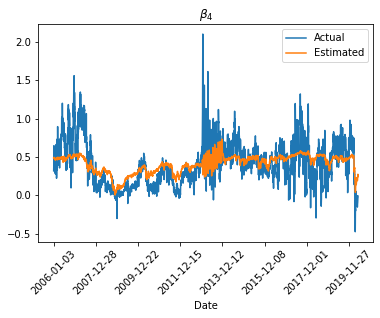

In [313]:
poly_params['x4'].plot(label='Actual')
pred['x4'].plot(label='Estimated')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.title(r'$\beta_4$')
plt.legend()
plt.savefig('plots/poly_beta_4.png')

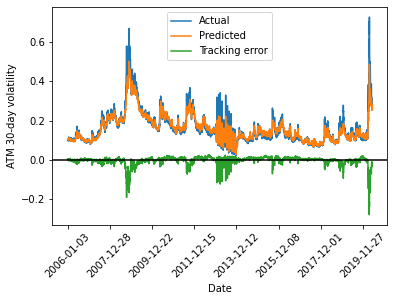

In [353]:
np.exp(poly_params @ [1, 0, 0, 30/365, 0]).plot(label='Actual')
np.exp(pred @ [1, 0, 0, 30/365, 0]).plot(label='Predicted')
(np.exp(pred @ [1, 0, 0, 30/365, 0]) - np.exp(poly_params @ [1, 0, 0, 30/365, 0])).plot(label='Tracking error')
plt.axhline(0, color='black')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Date'); plt.ylabel('ATM 30-day volatility')
plt.savefig('plots/poly_tracking.png')

# SVI

In [376]:
svi_params = pd.DataFrame(columns = ['a','b','rho','m','sigma'])
for obj in df_s['obj']:
    a,b,rho,m,sigma = (obj.sviParams.loc[:30/365].iloc[-1] + obj.sviParams.loc[30/365:].iloc[0]) / 2
    svi_params = svi_params.append(pd.Series(name=obj.date,data={'a':a,
                                    'b':b,
                                    'rho':rho,
                                    'm':m,
                                    'sigma': sigma
                                   }))

In [378]:
kf = KalmanFilter(n_dim_state=3, n_dim_obs=5, em_vars='all')
kf = kf.em(svi_params)
mean, cov = kf.filter(svi_params)
temp = mean @ kf.observation_matrices.T + kf.observation_offsets
pred = pd.DataFrame(index=svi_params.index, data=temp, columns=svi_params.columns)

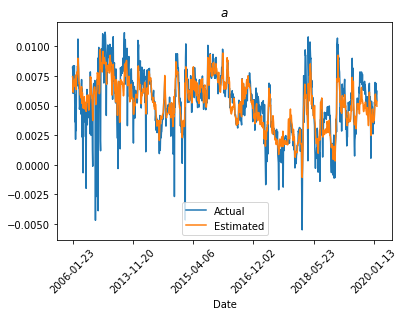

In [379]:
svi_params['a'].plot(label='Actual')
pred['a'].plot(label='Estimated')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.title(r'$a$')
plt.legend()
plt.savefig('plots/svi_a.png')

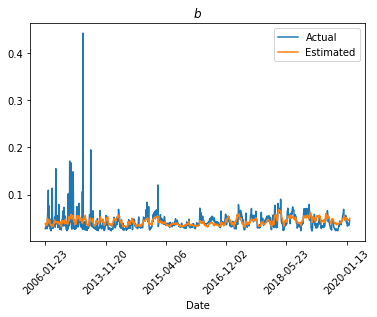

In [380]:
svi_params['b'].plot(label='Actual')
pred['b'].plot(label='Estimated')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.title(r'$b$')
plt.legend()
plt.savefig('plots/svi_b.png')

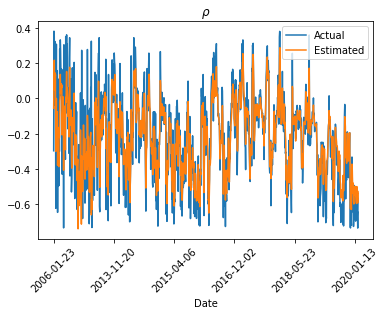

In [381]:
svi_params['rho'].plot(label='Actual')
pred['rho'].plot(label='Estimated')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.title(r'$\rho$')
plt.legend()
plt.savefig('plots/svi_rho.png')

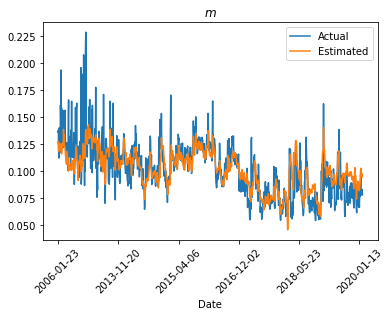

In [382]:
svi_params['m'].plot(label='Actual')
pred['m'].plot(label='Estimated')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.title(r'$m$')
plt.legend()
plt.savefig('plots/svi_m.png')

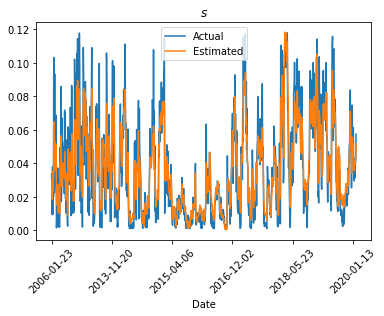

In [383]:
svi_params['sigma'].plot(label='Actual')
pred['sigma'].plot(label='Estimated')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.title(r'$s$')
plt.legend()
plt.savefig('plots/svi_s.png')

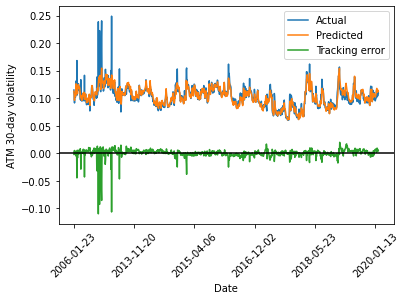

In [390]:
svi_params.apply(lambda x: np.sqrt(ivs.SVI.rawSVI(0, x)), axis=1).plot(label='Actual')
pred.apply(lambda x: np.sqrt(ivs.SVI.rawSVI(0, x)), axis=1).plot(label='Predicted')
(pred.apply(lambda x: np.sqrt(ivs.SVI.rawSVI(0, x)), axis=1) 
 - svi_params.apply(lambda x: np.sqrt(ivs.SVI.rawSVI(0, x)), axis=1)).plot(label='Tracking error')
plt.axhline(0, color='black')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Date'); plt.ylabel('ATM 30-day volatility')
plt.savefig('plots/svi_tracking.png')

# Cubic

In [391]:
cubic_params = pd.DataFrame(columns = ['x0','x1','x2','x3'])
for obj in df_c['obj']:
    x0,x1,x2,x3 = (obj.params.loc[:30/365].iloc[-1] + obj.params.loc[30/365:].iloc[0]) / 2
    cubic_params = cubic_params.append(pd.Series(name=obj.date,data={'x0':x0,'x1':x1,'x2':x2,'x3':x3
                                   }))

In [392]:
kf = KalmanFilter(n_dim_state=3, n_dim_obs=4, em_vars='all')
kf = kf.em(cubic_params)
mean, cov = kf.filter(cubic_params)
temp = mean @ kf.observation_matrices.T + kf.observation_offsets
pred = pd.DataFrame(index=cubic_params.index, data=temp, columns=cubic_params.columns)

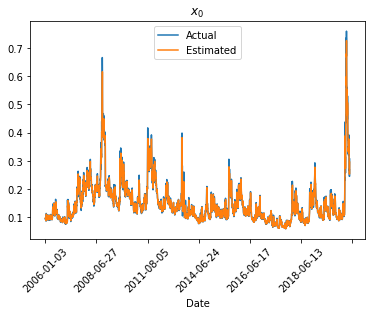

In [393]:
cubic_params['x0'].plot(label='Actual')
pred['x0'].plot(label='Estimated')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.title(r'$x_0$')
plt.legend()
plt.savefig('plots/cubic_x0.png')

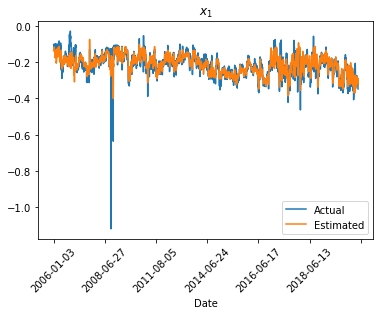

In [394]:
cubic_params['x1'].plot(label='Actual')
pred['x1'].plot(label='Estimated')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.title(r'$x_1$')
plt.legend()
plt.savefig('plots/cubic_x1.png')

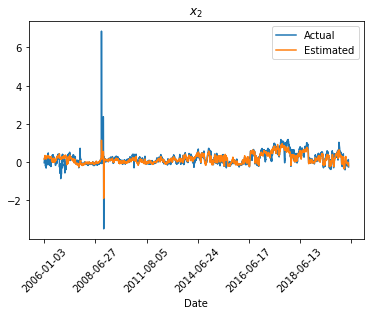

In [395]:
cubic_params['x2'].plot(label='Actual')
pred['x2'].plot(label='Estimated')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.title(r'$x_2$')
plt.legend()
plt.savefig('plots/cubic_x2.png')

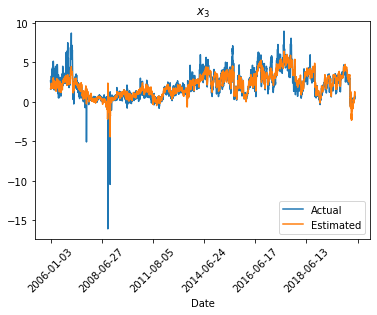

In [396]:
cubic_params['x3'].plot(label='Actual')
pred['x3'].plot(label='Estimated')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.title(r'$x_3$')
plt.legend()
plt.savefig('plots/cubic_x3.png')

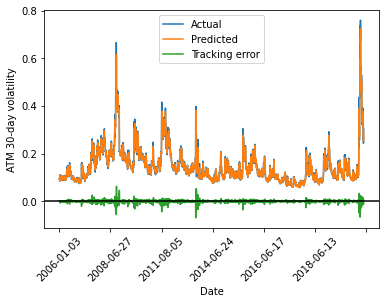

In [397]:
(cubic_params @ [1, 0, 0, 0]).plot(label='Actual')
(pred @ [1, 0, 0, 0]).plot(label='Predicted')
(pred @ [1, 0, 0, 0] - cubic_params @ [1, 0, 0, 0]).plot(label='Tracking error')
plt.axhline(0, color='black')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Date'); plt.ylabel('ATM 30-day volatility')
plt.savefig('plots/cubic_tracking.png')